In [ ]:
###
    # This code is to plot Bias in the simulated multi-year mean annual maximum (Tmax) and 
    # minimum (Tmin) soil temperatures relative to observations during the historical period (1982–2014).
    # Output: Figure S7.
###

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import TwoSlopeNorm
from scipy.stats import gaussian_kde
import string
from matplotlib.font_manager import FontProperties
import warnings
warnings.filterwarnings("ignore")

In [2]:
def multi_year_avg(file):
    Model_Soil_df = pd.read_csv(file)
    Model_Soil_df = Model_Soil_df.iloc[:,1:]
    tsl32_cols = [col for col in Model_Soil_df.columns if col.endswith('_tsl32')]

    # Group by station and year, calculate max and min values for each model simulation per station per year
    annual_stats = Model_Soil_df.groupby(['station', 'year'])[tsl32_cols].agg(['max', 'min'])

    # Calculate multi-year average for each station (average of annual max/min values across years)
    multi_year_avg = annual_stats.groupby('station').mean()

    # New structure: 'modelname_max' and 'modelname_min'
    multi_year_avg.columns = [f"{var}_{agg}" for var, agg in multi_year_avg.columns]
    
    return multi_year_avg

def all_station(depth):
    file = "/home/wangjx/Data/Ts"+str(depth)+"cm_Ts02cm_18model_stations.csv"
    all_station = multi_year_avg(file)
    return all_station

GFDL 1.6m: left_count = 28, right_count = 152
84.44444444444444 %
['GFDL family']
GFDL 2.4m: left_count = 13, right_count = 91
87.5 %
GFDL 3.2m: left_count = 34, right_count = 134
79.76190476190477 %
MPI 1.6m: left_count = 180, right_count = 0
0.0 %
['MPI family']
MPI 2.4m: left_count = 104, right_count = 0
0.0 %
MPI 3.2m: left_count = 168, right_count = 0
0.0 %
Other 1.6m: left_count = 438, right_count = 822
65.23809523809524 %
['Other models']
Other 2.4m: left_count = 192, right_count = 536
73.62637362637363 %
Other 3.2m: left_count = 417, right_count = 759
64.54081632653062 %


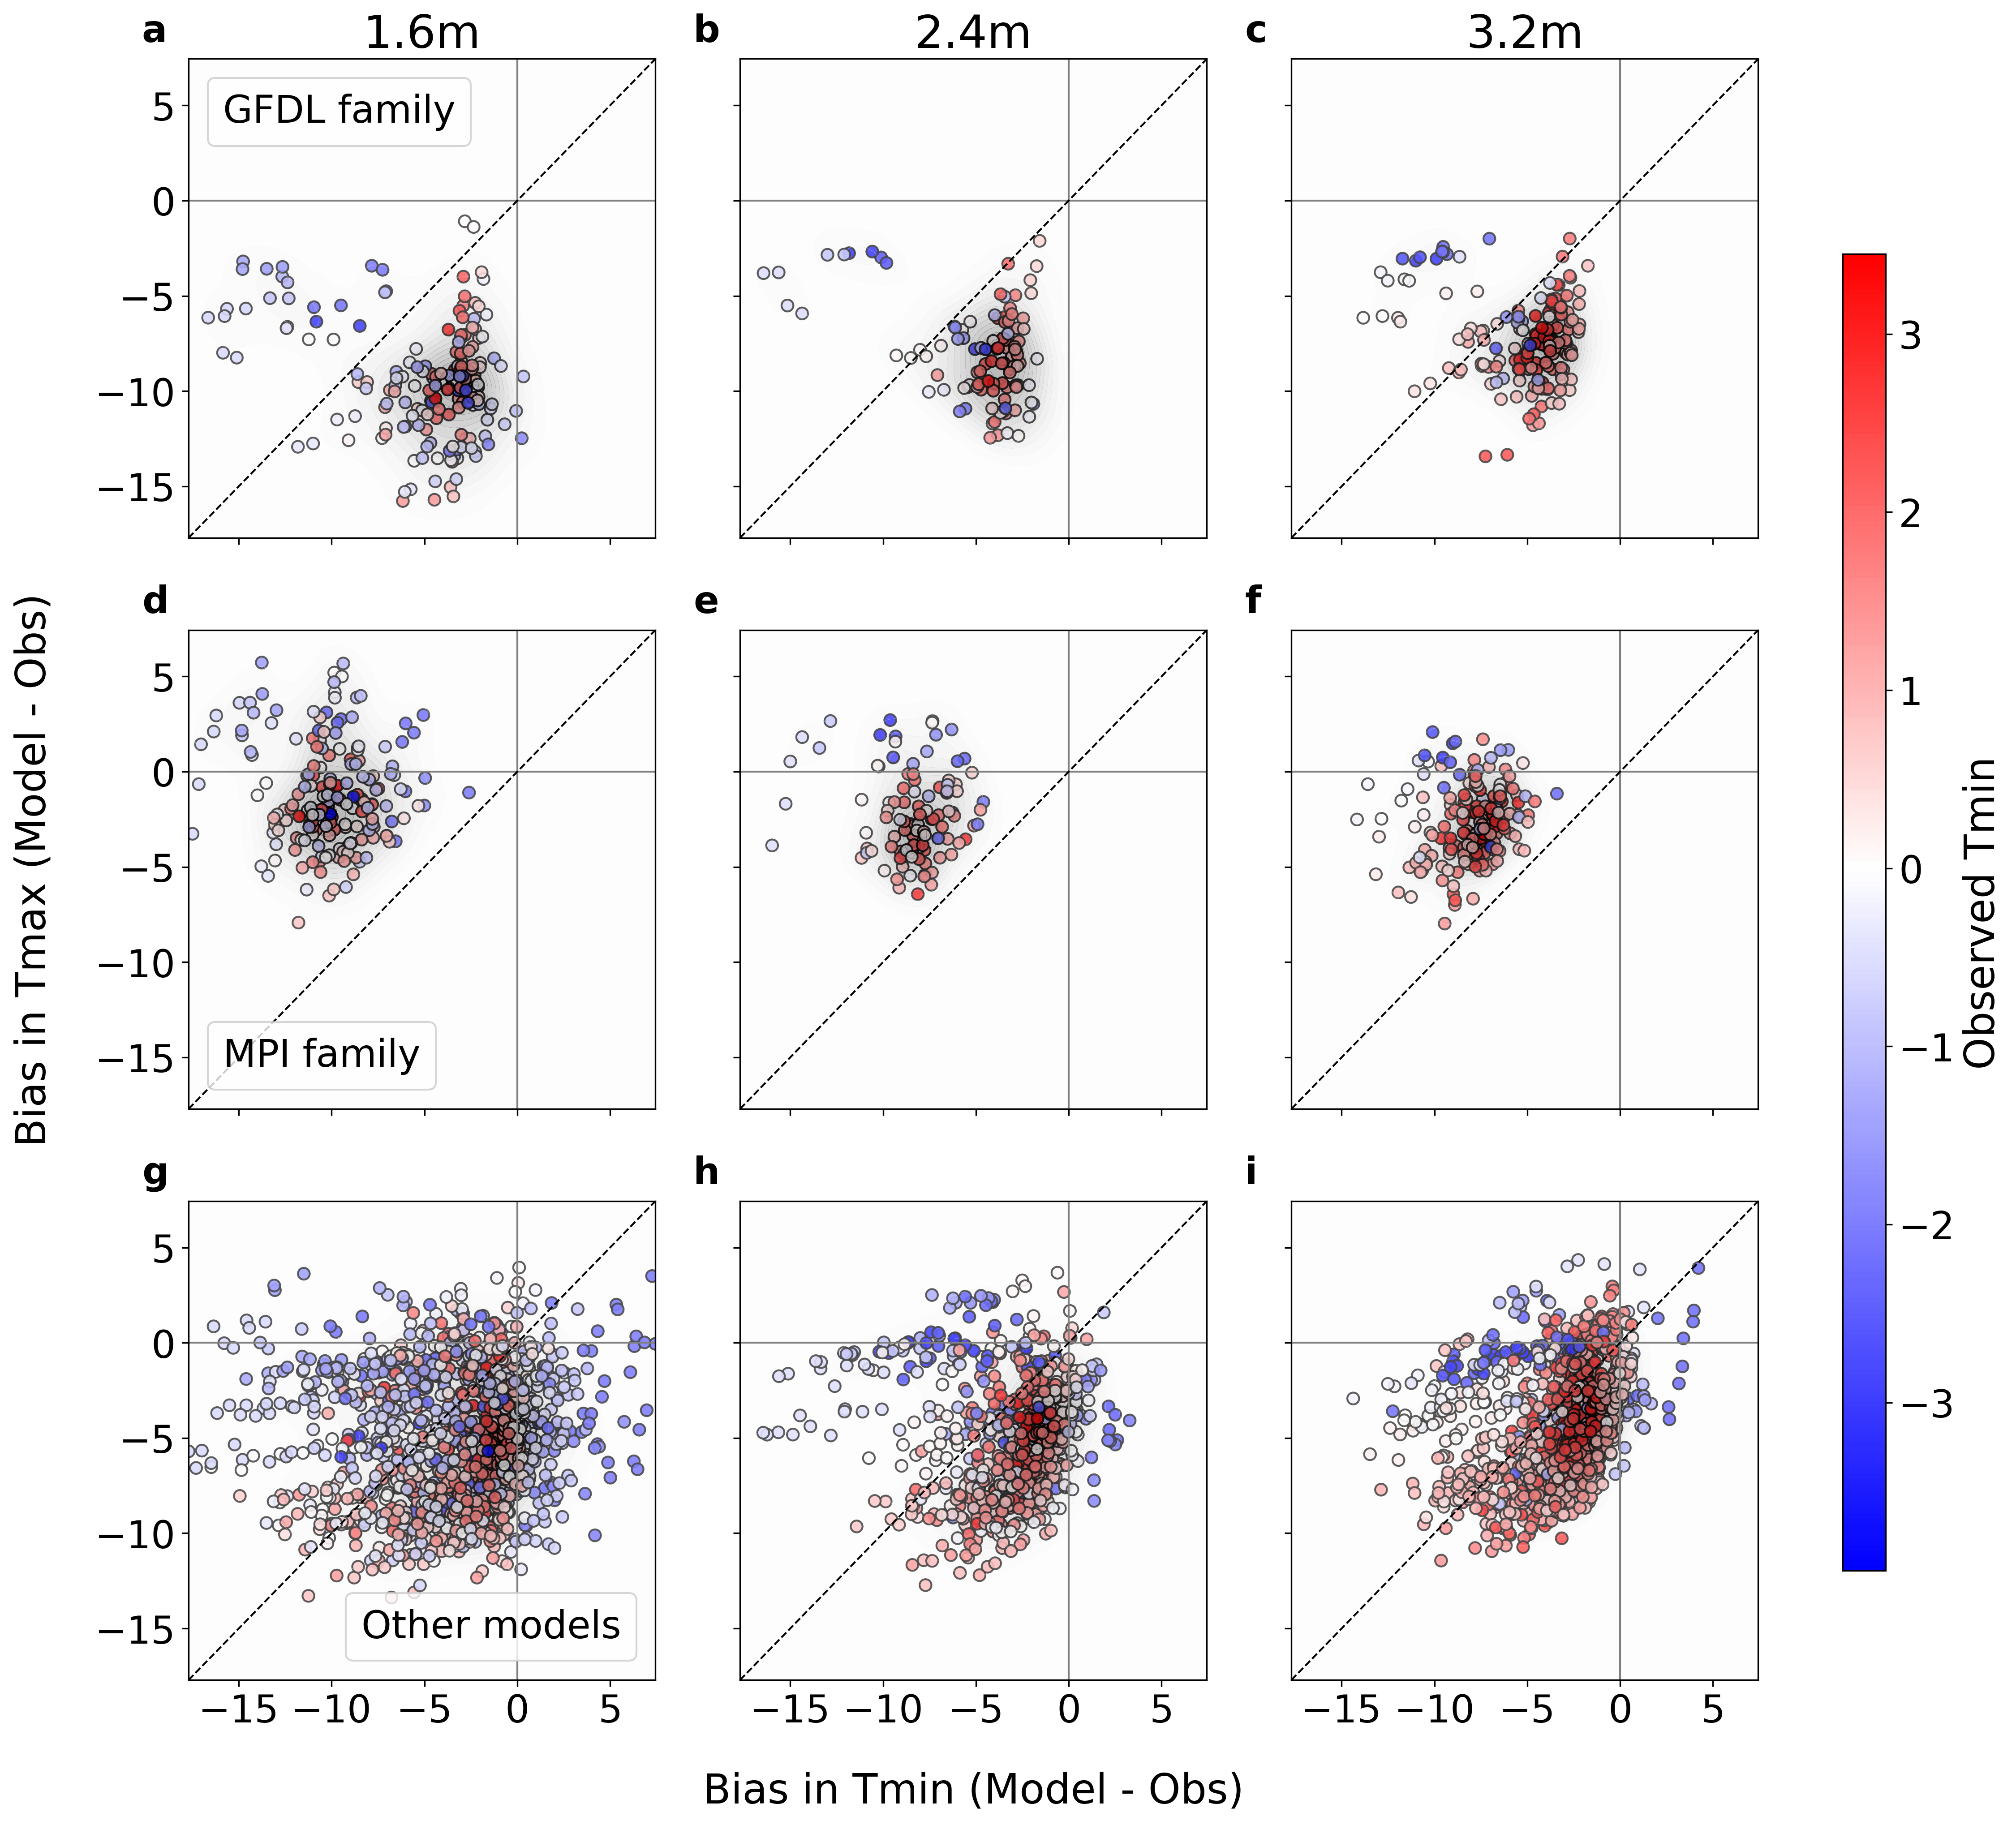

In [3]:
# Put three datasets into a list
datasets = [all_station(160), all_station(240), all_station(320)]
titles = ["1.6m", "2.4m", "3.2m"]
LETTERS = list(string.ascii_lowercase)

# Pre-calculate global x and y axis ranges for all datasets
global_x_min = np.inf
global_x_max = -np.inf
global_y_min = np.inf
global_y_max = -np.inf

for data in datasets:
    # Extract model names (non-observation columns ending with "_max", model name is the part before the first underscore)
    model_cols = [col for col in data.columns if not col.startswith("obs_")]
    max_cols = [col for col in model_cols if col.endswith("_max")]
    models = sorted(list({col.split('_')[0] for col in max_cols}))
    
    for model in models:
        diff_min = data[f"{model}_tsl32_min"] - data["obs_tsl32_min"]
        diff_max = data[f"{model}_tsl32_max"] - data["obs_tsl32_max"]
        global_x_min = min(global_x_min, diff_min.min(), global_y_min, diff_max.min())
        global_x_max = max(global_x_max, diff_min.max(), global_y_max, diff_max.max())
        global_y_min = min(global_y_min, diff_max.min(), global_x_min, diff_min.min())
        global_y_max = max(global_y_max, diff_max.max(), global_x_max, diff_min.max())

# Adjust global font size
plt.rcParams.update({'font.size': 20.5})
# Use a fixed color scale range consistently
norm = TwoSlopeNorm(vmin=-4, vcenter=0, vmax=4)

# ---------------------------
# Create 3x3 subplot layout
# ---------------------------
fig, axes = plt.subplots(3, 3, figsize=(16, 14), dpi=300, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# Define model groups
model_groups = {
    'GFDL': {'models': [], 'row': 0, 'marker': 'o', 'label': 'GFDL family'},
    'MPI': {'models': [], 'row': 1, 'marker': 'o', 'label': 'MPI family'},
    'Other': {'row': 2, 'marker': 'o', 'label': 'Other models'}
}

# ---------------------------
# Classify all models
# ---------------------------
for data in datasets:
    model_cols = [col for col in data.columns if not col.startswith("obs_")]
    max_cols = [col for col in model_cols if col.endswith("_max")]
    models = sorted(list({col.split('_')[0] for col in max_cols}))
    
    for model in models:
        if model.startswith("GFDL"):
            if model not in model_groups['GFDL']['models']:
                model_groups['GFDL']['models'].append(model)
        elif model.startswith("MPI"):
            if model not in model_groups['MPI']['models']:
                model_groups['MPI']['models'].append(model)

# ---------------------------
# Plot each group
# ---------------------------
for group_name, group_info in model_groups.items():
    row = group_info['row']
    
    for col, (data, title) in enumerate(zip(datasets, titles)):
        ax = axes[row, col]
        
        # Extract models for current group
        if group_name == 'Other':
            # Other models are those not in GFDL or MPI groups
            all_models = sorted(list({col.split('_')[0] for col in data.columns 
                                   if not col.startswith("obs_") and col.endswith("_max")}))
            models = [m for m in all_models 
                     if not m.startswith("GFDL") and not m.startswith("MPI")]
        else:
            models = [m for m in group_info['models'] if m in data.columns.str.split('_').str[0]]
        
        # For density calculation, store all scatter data
        all_diff_min_list = []
        all_diff_max_list = []
        
        # Set color scale range
        vmin = data["obs_tsl32_min"].min()
        vmax = data["obs_tsl32_min"].max()
        norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
        
        # Plot models in current group
        for model in models:
            diff_min = data[f"{model}_tsl32_min"] - data["obs_tsl32_min"]
            diff_max = data[f"{model}_tsl32_max"] - data["obs_tsl32_max"]
            all_diff_min_list.append(diff_min.values)
            all_diff_max_list.append(diff_max.values)
            obs_tmin = data["obs_tsl32_min"]
            
            # Only add labels in the first column
            label = group_info['label'] if col == 0 else None
            ax.scatter(diff_min, diff_max,
                       c=obs_tmin, cmap='bwr', norm=norm,
                       marker=group_info['marker'],
                       s=40, edgecolor='black',
                       alpha=0.9,
                       label=label)
            ax.set_xticks(np.arange(-15, 10, 5))
            ax.set_yticks(np.arange(-15,10, 5))

        # Combine all scatter data for density estimation
        if all_diff_min_list:  # Check if list is not empty
            all_diff_min_array = np.concatenate(all_diff_min_list)
            all_diff_max_array = np.concatenate(all_diff_max_list)
            
            # Calculate scatter density
            xy = np.vstack([all_diff_min_array, all_diff_max_array])
            kde = gaussian_kde(xy)
            xgrid = np.linspace(global_x_min, global_x_max, 100)
            ygrid = np.linspace(global_y_min, global_y_max, 100)
            X, Y = np.meshgrid(xgrid, ygrid)
            positions = np.vstack([X.ravel(), Y.ravel()])
            Z = np.reshape(kde(positions), X.shape)
            ax.contourf(X, Y, Z, levels=15, cmap='Greys', alpha=0.3)

            # Count points on each side of y=x line
            left_count = np.sum(all_diff_max_array > all_diff_min_array)
            right_count = np.sum(all_diff_max_array < all_diff_min_array)
            print(f"{group_name} {title}: left_count = {left_count}, right_count = {right_count}")
            print(right_count/(right_count+left_count)*100,"%")
        
        # Add reference lines
        ax.axhline(0, color='gray', lw=1)
        ax.axvline(0, color='gray', lw=1)
        ax.plot([global_x_min, global_x_max],
                [global_x_min, global_x_max],
                linestyle='--', color='black', linewidth=1)
        
        # Set axis limits
        ax.set_xlim(global_x_min, global_x_max)
        ax.set_ylim(global_y_min, global_y_max)
        
        # Add subplot labels (a, b, c, etc.)
        subplot_idx = row * 3 + col
        ax.text(-0.1, 1.02, LETTERS[subplot_idx],
                transform=ax.transAxes,
                fontproperties=FontProperties(weight='bold', size=20),
                verticalalignment='bottom',
                color='black')
        
        # Set titles and axis labels
        if row == 0:
            ax.set_title(title)
        if row == 2:
            if col == 1:
                ax.set_xlabel("Bias in Tmin (Model - Obs)", labelpad=22, fontsize=22)
        if col == 0:
            if row == 1:
                ax.set_ylabel("Bias in Tmax (Model - Obs)", labelpad=22, fontsize=22)
        
        # Add legend (only in first column)
        if col == 0:
            handles, labels = ax.get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            keys = list(by_label.keys())
            if "Other models" in keys:
                keys.remove("Other models")
                keys.append("Other models")
            new_handles = [by_label[k] for k in keys]
            new_labels = keys
            print(new_handles)
            print(new_labels)
            ax.legend( new_labels, loc='best',handlelength=0,  # Set marker length to 0
            handletextpad=0)

# ---------------------------
# Create colorbar
# ---------------------------
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])
mappable = plt.cm.ScalarMappable(cmap='bwr', norm=norm)
mappable.set_array([])
cbar = fig.colorbar(mappable, cax=cbar_ax, orientation='vertical')
cbar.set_label("Observed Tmin",fontsize=22)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [4]:
fig.savefig("../Figures/FigureS7.png", bbox_inches='tight',dpi=300)